In [23]:
# CONFIG CELL
from notebook_utils import set_root_directory

set_root_directory()

In [24]:
import geopandas as gpd
import numpy as np
import pandas as pd

from app import constants
from app.interpolator import Interpolator, knn_one_euclidean_method, thin_plate_spline_method

In [25]:
INPUT_VALUES_PATH = "input_files/measurements_24h.parquet"
INPUT_SENSOR_PATH = "input_files/sensor_metadata.parquet"

POLSKA = "polska.zip"

DS = "2023-01-01"

In [26]:
poland = gpd.read_file(POLSKA).to_crs(constants.POLAND_EPSG)

In [27]:
min_x, min_y, max_x, max_y = poland.total_bounds

x = np.linspace(min_x, max_x, int((max_x - min_x) / 2500) + 1)
y = np.linspace(min_y, max_y, int((max_y - min_y) / 2500) + 1)

grid = np.meshgrid(x, y)

grid = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(
        x=grid[0].flatten(),
        y=grid[1].flatten(),
    ),
    crs=constants.POLAND_EPSG,
)

result_grid = gpd.sjoin(grid, poland, how="inner", predicate="intersects")
result_grid = result_grid.drop(columns=["index_right"])[[constants.GEOMETRY]]
result_grid[constants.LATITUDE] = result_grid[constants.GEOMETRY].y
result_grid[constants.LONGITUDE] = result_grid[constants.GEOMETRY].x
result_grid = result_grid.reset_index(drop=True)

In [28]:
values = pd.read_parquet(INPUT_VALUES_PATH)
values = values.query(f"{constants.TIMESTAMP_COLUMN} == '{DS}'")
values = values.query(f"{constants.PM10}.notna()")
values = values[[constants.TIMESTAMP_COLUMN, constants.UNIQUE_ID, constants.PM10]]
values = values.rename(
    columns={
        constants.PM10: constants.Y,
    }
)
values.head(5)

C:\Users\Mambo\AppData\Local\Temp\ipykernel_29348\2089838562.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  values = values.query(f"{constants.TIMESTAMP_COLUMN} == '{DS}'")


,ds,unique_id,y
34699,2023-01-01,182,12.7
78529,2023-01-01,267,19.0
183721,2023-01-01,999,14.3
648319,2023-01-01,295,15.8
727213,2023-01-01,316,14.4


In [29]:
sensors = pd.read_parquet(INPUT_SENSOR_PATH)
sensors = sensors[[constants.SENSOR_ID, constants.LATITUDE, constants.LONGITUDE]]
sensors = gpd.GeoDataFrame(
    sensors,
    geometry=gpd.points_from_xy(
        x=sensors[constants.LONGITUDE],
        y=sensors[constants.LATITUDE],
    ),
    crs=constants.GLOBAL_EPSG,
)
sensors = sensors.to_crs(constants.POLAND_EPSG)
sensors = sensors.drop(columns=[constants.LATITUDE, constants.LONGITUDE])
sensors = sensors.rename(
    columns={
        constants.SENSOR_ID: constants.UNIQUE_ID,
    }
)
sensors[constants.LATITUDE] = sensors[constants.GEOMETRY].y
sensors[constants.LONGITUDE] = sensors[constants.GEOMETRY].x
sensors = sensors[
    [constants.UNIQUE_ID, constants.LATITUDE, constants.LONGITUDE, constants.GEOMETRY]
]
sensors = sensors.reset_index(drop=True)
sensors.head(5)

,unique_id,latitude,longitude,geometry
0,1,374065.661816,298668.207625,POINT (298668.208 374065.662)
1,2,315542.220192,331731.887510,POINT (331731.888 315542.22)
2,4,345410.363310,216578.955300,POINT (216578.955 345410.363)
3,5,349773.073346,213026.328301,POINT (213026.328 349773.073)
4,3,349509.925544,213255.581789,POINT (213255.582 349509.926)


In [30]:
values_merged = pd.merge(sensors, values, on=constants.UNIQUE_ID, how="right", validate="1:1")
values_merged = gpd.GeoDataFrame(
    values_merged,
    geometry=constants.GEOMETRY,
    crs=constants.POLAND_EPSG,
)
values_merged.head(5)

,unique_id,latitude,longitude,geometry,ds,y
0,182,558122.320363,485263.211307,POINT (485263.211 558122.32),2023-01-01,12.7
1,267,470683.481562,784526.646563,POINT (784526.647 470683.482),2023-01-01,19.0
2,999,699874.375076,698458.291737,POINT (698458.292 699874.375),2023-01-01,14.3
3,295,384479.589007,747645.095265,POINT (747645.095 384479.589),2023-01-01,15.8
4,316,325407.642700,802727.997035,POINT (802727.997 325407.643),2023-01-01,14.4


In [31]:
interpolator_knn = Interpolator(method=knn_one_euclidean_method, points=values_merged)
output_knn = interpolator_knn.fit_transform(
    X=result_grid,
)

In [32]:
display(interpolator_knn.metrics)

{'MAPE': 0.2847042693706738,
 'MAE': 7.118164556962026,
 'RMSE': 14.101871206296963}

<Axes: >

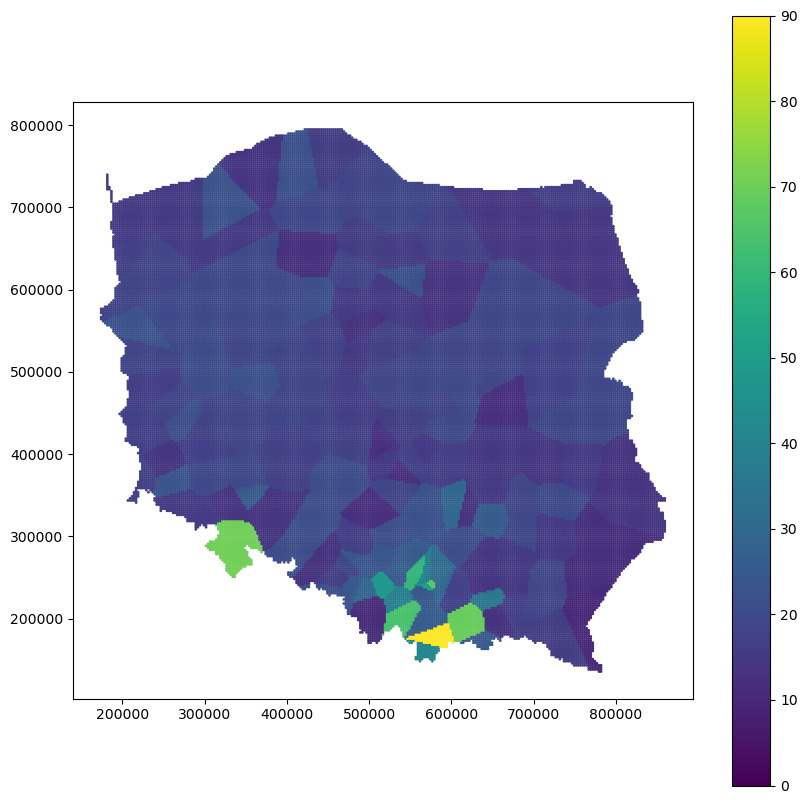

In [33]:
output_knn.plot(
    column=constants.Y,
    cmap="viridis",
    legend=True,
    figsize=(10, 10),
    markersize=1,
    vmin=0,
    vmax=90,
)

In [34]:
interpolator_tps = Interpolator(method=thin_plate_spline_method, points=values_merged)
output_tps = interpolator_tps.fit_transform(
    X=result_grid,
)

In [35]:
display(interpolator_tps.metrics)

{'MAPE': 0.3249664749969743,
 'MAE': 7.826187475590371,
 'RMSE': 14.815425921343994}

<Axes: >

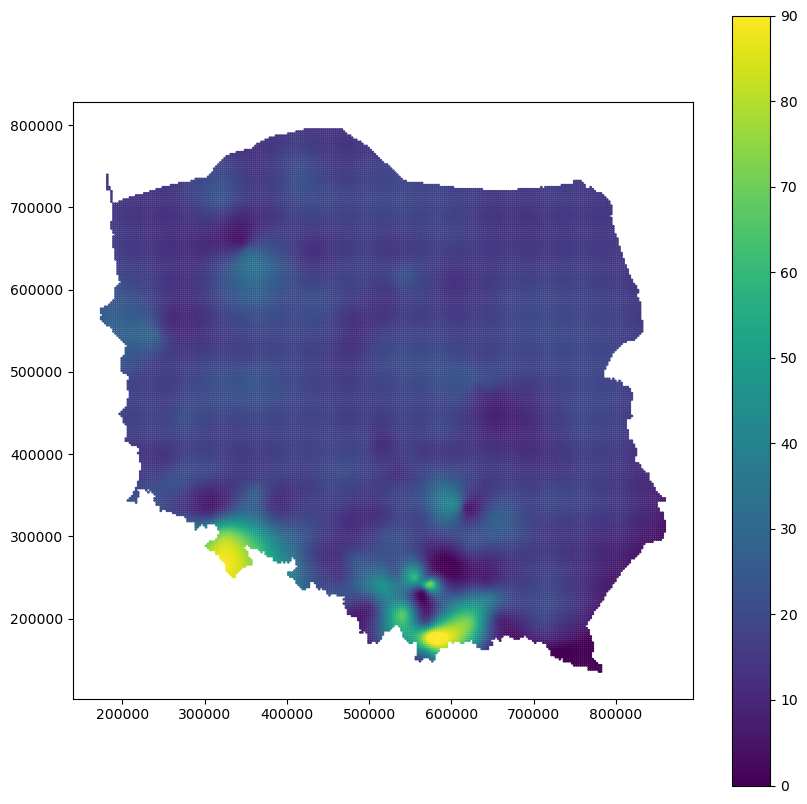

In [36]:
output_tps.plot(
    column=constants.Y,
    cmap="viridis",
    legend=True,
    figsize=(10, 10),
    markersize=1,
    vmin=0,
    vmax=90,
)